In [1]:
# http://pytorch.org/

colab = False
from copy import deepcopy

from os import path
if colab:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.autograd import Variable
from torch.nn import init
from torch.optim import Adam, SGD
import torch.nn as nn
import numpy as np
from scipy.signal import savgol_filter

from scipy.signal import savgol_filter

from torch.optim import Adam, SGD

import matplotlib.pyplot as plt
%matplotlib inline

device = "cpu"
if device == "cpu":
    from torch import FloatTensor
else:
    from torch.cuda import FloatTensor

In [2]:
def weights_init(m, std):
  vals = list(m.parameters())[0]
  vals.data.normal_(0.0, std)

def get_return(agent_a, agent_b, overwrite = None, temp = 1, collapse = True):
  if overwrite is not None:
    batchsize = overwrite.data.numpy().shape[0]
    weights_a = overwrite
    agent_a_in_b = overwrite
  else:
    weights_a = list(agent_a.parameters())[0].transpose(1,0)
    batchsize = weights_a.data.numpy().shape[0]
  if stop_grad:
    agent_a_in_b = weights_a.clone().detach()
  else:
    agent_a_in_b = weights_a
  pi_b = nn.Softmax(1)( agent_b(  agent_a_in_b )*1) # prob of agent B cooperating given agent A's policy 
  rews = torch.tensor([[0.0, 0.0]]*batchsize )
  for u_b in [0,1]:
    p_u_b = pi_b[:,u_b]
    pi_a =  nn.Softmax(0)(torch.stack((weights_a[:,u_b],weights_a[:,u_b] * 0)))    # weird hack with *0
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[:,0]+= prob * payout[ u_a, u_b]   
      rews[:,1]+= prob * payout[ u_b, u_a]
  # if collapse we'll be assuming the pi_a runs a softmax policy over the expected return for a given pi_A
  if collapse:
      p_a = nn.Softmax(0)(rews[:,0]* temp)
      final_ret_b = torch.sum(p_a*rews[:,1])  
      final_ret_a = torch.sum(p_a*rews[:,0]) 
      return [-final_ret_a, -final_ret_b]
  # otherwise we return the current values uncollapsed
  else:
      return -rews

def printnetwork(x_range):
  numvals = 30
  results = np.zeros((numvals, numvals))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      results[x, y ] = nn.Softmax(0)( agent_b(  torch.tensor([-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range] )) )[0] # prob of agent B cooperating given agentA's policy
  plt.imshow(results.T,cmap = 'jet', origin='lower')
  ax = plt.gca()
  ax.set_xticks(np.arange(0, numvals+1,numvals//5))
  ax.set_yticks(np.arange(0, numvals+1,numvals//5))
  ax.set_xticklabels(np.round((100*np.arange(-x_range, x_range+0.1, 1 /5 * 2* x_range))//1 / (2*numvals), 1))
  ax.set_yticklabels(np.round((100*np.arange(-x_range, x_range+0.1, 1 /5 * 2* x_range))//1 /(2* numvals), 1))

def printagentaval(x_range):
  numvals = 100
  results = np.zeros((numvals, numvals, 2))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      overwrite = torch.tensor([[-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range]] )
      results[x, y ] =  -get_return(agent_a, agent_b, overwrite=overwrite, collapse = False).data 
  return results

nonlin = nn.ReLU()
    
def get_agent_a(batchsize):
  a = nn.Sequential(
    nn.Linear(batchsize, 2, bias=False),
  )
  return a

def get_agent_b(batchsize):
  b = nn.Sequential(
      nn.Linear(2, 32),
      nonlin,
      nn.Linear(32, 32),
      nonlin,
  #     nn.Linear(32, 32),
  #     nn.ReLU(),
      nn.Linear(32, 2)
  )
  return b

def set_weight(m, overwrite):
  vals = list(m.parameters())[0]
  vals.data = overwrite
    
payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)


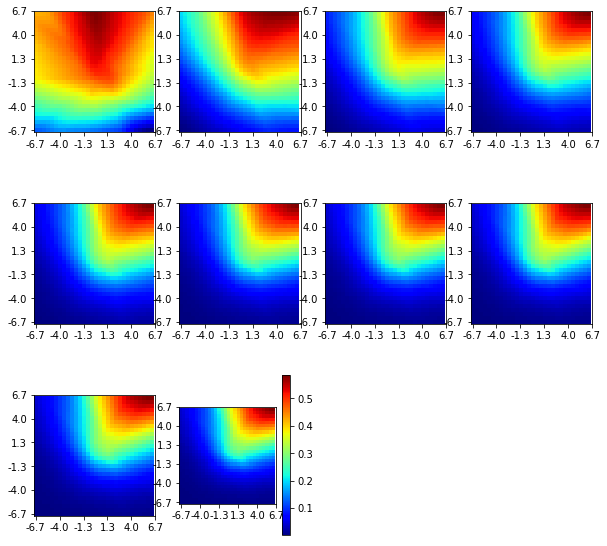

In [4]:
t = True
f = False

p = f
stop_grad = f
cooperative = f

gs = 11 # grid size
batchsize = gs**2
vals = np.zeros((2,batchsize))
tic = 0
x_range = 4
def log_p( p , eps = 0.01):
    p = min(1-eps, max(eps, p))
    the = -np.log(p / (1-p) )
    return the

for x in range(gs):
    for y in range(gs):
        x_s = log_p(x/(gs-1))
        y_s = log_p(y/(gs-1))
        vals[:, tic] = [x_s, y_s]
        tic += 1

agent_a = get_agent_a(batchsize)
agent_b = get_agent_b(batchsize)

lrs = [0.05, 0.005]
ops = [SGD, SGD]

for i, net in enumerate([agent_a, agent_b]):
  net.optimizer = ops[i](net.parameters(), lr=lrs[i])

overwrite = torch.tensor(vals,  dtype=torch.float)
set_weight(agent_a, overwrite)

plt.figure(figsize=(10,10))
steps = 500
rets = np.zeros( (steps,2 ))
for step in range( steps ):
    obj = get_return(agent_a, agent_b,temp=50)
    objective1 =  obj[1]
    rets[step, 1 ] = objective1.data.numpy()
    rets[step, 0 ] = obj[0].data.numpy()
    agent_b.optimizer.zero_grad()
    objective1.backward()
    agent_b.optimizer.step()
    if step % (steps//10) == 0:
        plt.subplot(3,4, int( step / (steps//10)) +1 )
        printnetwork(x_range)
        
plt.colorbar()    
None

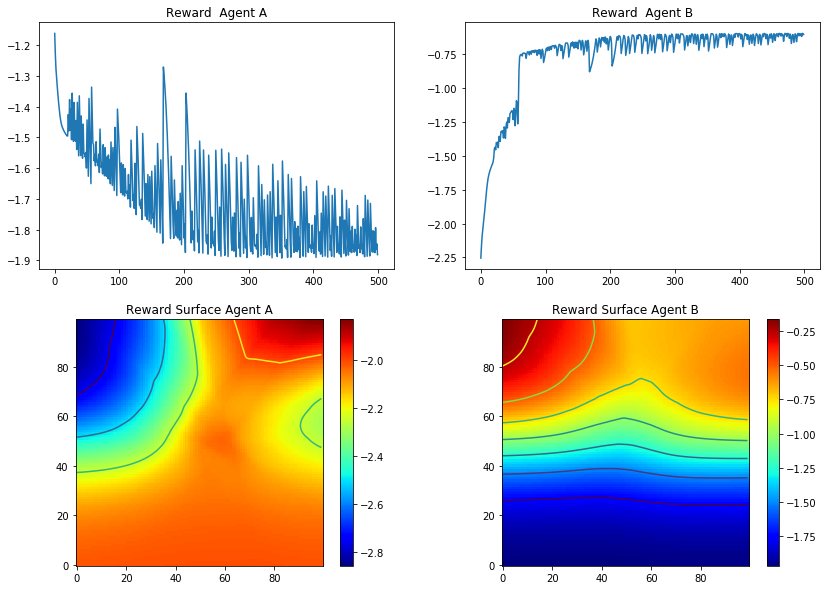

In [12]:
plt.figure(figsize = (14,10))
plt.subplot(2,2,1)
plt.plot( -rets[:,0])
plt.title('Reward  Agent A')

plt.subplot(2,2,2)
plt.plot( -rets[:,1])
plt.title('Reward  Agent B')

res = printagentaval(x_range)
plt.subplot(2,2,3)
plt.imshow( res[:,:,0].T,cmap = 'jet', origin='lower')
plt.colorbar()


plt.contour(res[:,:,0].T, [-2.75, -2.5, -2.25, -2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25])

plt.title('Reward Surface Agent A')

plt.subplot(2,2,4)
plt.imshow( res[:,:,1].T,cmap = 'jet', origin='lower')
plt.colorbar()

plt.contour(res[:,:,1].T, [-1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25])
plt.title('Reward Surface Agent B')

None



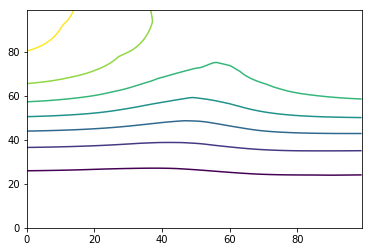

In [7]:
plt.contour(res[:,:,1].T, [-1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25])